<a href="https://colab.research.google.com/github/JkoolCode/TFM_Maestria_IA/blob/main/01_3_Random_Forest_Regressor_OTM_Options_SPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High-Ram Validation

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.

# Lectura CSV

In [ ]:
import pandas as pd
df_spy = pd.read_csv('spy_options_call_output_all.csv')

In [ ]:
# Seleccionar solo OTM
df_spy = df_spy[df_spy['moneyness_category'] == 'OTM']

In [ ]:
# Ordenar cronológicamente el dataset
df_spy = df_spy.sort_values(by=['quote_date', 'expire_date'], ascending=True).reset_index(drop=True)

In [ ]:
# Verificar si esta ordenado correctamente
print(df_spy['quote_date'].head())
print(df_spy['quote_date'].tail())

0    2020-01-02
1    2020-01-02
2    2020-01-02
3    2020-01-02
4    2020-01-02
Name: quote_date, dtype: object
61639    2023-12-28
61640    2023-12-28
61641    2023-12-28
61642    2023-12-28
61643    2023-12-29
Name: quote_date, dtype: object


In [ ]:
df_spy.head()

,quote_date,expire_date,dte,underlying_last,strike,strike_distance,strike_distance_pct,c_last,c_bid,c_ask,...,relative_spread,dte_year,c_volume_log,c_volume_log_scaled,volume_zero,moneyness,iv_pct_rank,c_iv_min,iv_skew,spread_mid_price
0,2020-01-02,2020-01-03,1.0,324.87,331.5,6.6,0.020,0.05,0.0,0.02,...,2.0,0.003968,2.708050,0.396255,0,0.980000,0.615385,0.07086,0.03798,2.0
1,2020-01-02,2020-01-03,1.0,324.87,332.0,7.1,0.022,0.01,0.0,0.02,...,2.0,0.003968,1.945910,0.284735,0,0.978524,0.628205,0.07086,0.04462,2.0
2,2020-01-02,2020-01-03,1.0,324.87,332.5,7.6,0.023,0.02,0.0,0.02,...,2.0,0.003968,3.688879,0.539775,0,0.977053,0.692308,0.07086,0.05172,2.0
3,2020-01-02,2020-01-03,1.0,324.87,336.0,11.1,0.034,0.03,0.0,0.02,...,2.0,0.003968,4.304065,0.629792,0,0.966875,0.846154,0.07086,0.10017,2.0
4,2020-01-02,2020-01-03,1.0,324.87,340.0,15.1,0.047,0.01,0.0,0.02,...,2.0,0.003968,0.693147,0.101425,0,0.955500,0.910256,0.07086,0.15350,2.0


In [ ]:
df_spy.shape

(61644, 31)

# Features

In [ ]:
df_spy.groupby('anio').size()

,0
anio,
2020,8552
2021,11582
2022,22410
2023,19100


In [ ]:
# Test data
df_spy_2023 = df_spy[df_spy['anio'] == 2023]

In [ ]:
# Train data
df_spy = df_spy[df_spy['anio'] < 2023]

In [ ]:
# target_train = 'c_mid_price'
# target_test = 'c_last'

features_cols = [
                 # Variables Black Scholes (captura el comportamiento teorico del precio de la opcion)
                 'moneyness', # contiene a 'underlying_last' y 'strike'
                 'dte_year',
                 'c_iv',
                  # Variables que capturan micro-comportamientos del precio real de la opcion (utilizando 'c_mid_price' en periodo de entrenamiento)
                 'iv_skew',
                 'iv_pct_rank',
                 'c_volume_log_scaled', # volumen y liquidez
                 # Indicadores Greeks (aportan estructura del modelo BS)
                 'c_delta',
                 'c_gamma',
                 'c_vega',
                 'c_theta'
                  ]

In [ ]:
# target_train = 'c_last' # Para predecir el precio real transado de una opcion (Hacer un modelo robusto a mercado real, existe mucho mas ruido del mercado)
target_train = 'c_mid_price' # Para predecir (modelar) el precio teorico justo o replicar Black-Scholes
target_test = 'c_last'

In [ ]:
X = df_spy[features_cols]
y = df_spy[target_train]

In [ ]:
X_test_2023 = df_spy_2023[features_cols]
y_test_2023 = df_spy_2023[target_test]

In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


In [ ]:
X.describe()

,moneyness,dte_year,c_iv,iv_skew,iv_pct_rank,c_volume_log_scaled,c_delta,c_gamma,c_vega,c_theta
count,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000,42544.000000
mean,0.948687,0.016419,0.253600,0.039437,0.211613,0.593682,0.089908,0.019174,0.054415,-0.105459
std,0.051679,0.009590,0.200360,0.192042,0.184446,0.236086,0.131893,0.042988,0.065635,0.156076
min,0.564118,0.000000,0.014980,-1.086930,0.001412,0.000000,0.000110,0.000000,0.000000,-0.999080
25%,0.933674,0.007937,0.141908,-0.026992,0.081023,0.443158,0.005500,0.001650,0.006800,-0.141407
50%,0.962751,0.015873,0.206040,0.016630,0.156639,0.628424,0.018705,0.006245,0.020270,-0.027415
75%,0.982500,0.023810,0.284795,0.105692,0.281737,0.768377,0.122847,0.024930,0.088432,-0.010570
max,0.999979,0.031905,2.974060,2.722760,1.000000,1.000000,0.554450,1.201350,0.296370,-0.002000


In [ ]:
print(df_spy['moneyness_category'].value_counts())
print(df_spy['moneyness_category'].value_counts(normalize=True)*100)

moneyness_category
OTM    42544
Name: count, dtype: int64
moneyness_category
OTM    100.0
Name: proportion, dtype: float64


In [ ]:
y.describe()

,c_mid_price
count,42544.000000
mean,0.493763
std,1.000880
min,0.010000
25%,0.015000
50%,0.050000
75%,0.425000
max,14.400000


In [ ]:
print("cantidad features:", X.shape[1])
print("cantidad target:", len(y.shape))

cantidad features: 10
cantidad target: 1


In [ ]:
X.dtypes

,0
moneyness,float64
dte_year,float64
c_iv,float64
iv_skew,float64
iv_pct_rank,float64
c_volume_log_scaled,float64
c_delta,float64
c_gamma,float64
c_vega,float64
c_theta,float64


# Random Forest Regressor

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Entrenamiento

In [ ]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y

# transformamos el target con log1p
y_train_log = np.log1p(y_train)

In [ ]:
y_train.describe()

,c_mid_price
count,42544.000000
mean,0.493763
std,1.000880
min,0.010000
25%,0.015000
50%,0.050000
75%,0.425000
max,14.400000


In [ ]:
y_train_log.describe()

,c_mid_price
count,42544.000000
mean,0.278289
std,0.433027
min,0.009950
25%,0.014889
50%,0.048790
75%,0.354172
max,2.734368


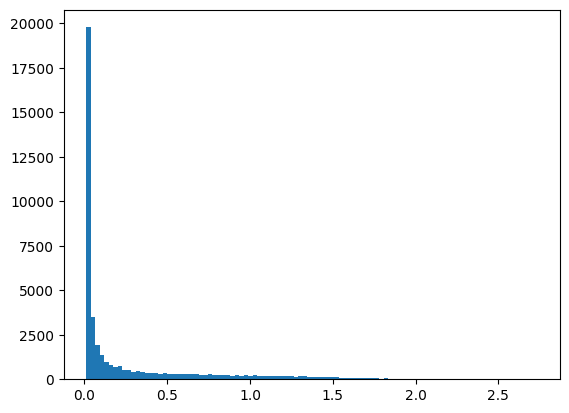

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_log, bins=100);

In [ ]:
print(f"Cantidad Registros para X_train: {X_train.shape[0]}")

Cantidad Registros para X_train: 42544


In [ ]:
print(f"Cantidad Registros para X_test_2023: {X_test_2023.shape[0]}")

Cantidad Registros para X_test_2023: 19100


### mini-prueba

In [ ]:
start_time = time.time()

rf = RandomForestRegressor(
    n_estimators=100,     # número de árboles base (300–500 es típico)
    max_depth=None,       # deja que crezca hasta detenerse naturalmente
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1             # usa todos los núcleos del CPU
)
rf.fit(X_train, y_train_log)

end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Training time: 8.208438158035278 seconds


Prediccion

In [ ]:
# Make predictions on the test set
start_time = time.time()

y_pred_log = rf.predict(X_test_2023)

end_time = time.time()
print(f"Prediction time: {end_time - start_time} seconds")

Prediction time: 0.08506989479064941 seconds


Metricas

In [ ]:
# Destransformar predicciones
y_pred = np.expm1(y_pred_log)

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_2023, y_pred)
mse = mean_squared_error(y_test_2023, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE manually
r2 = r2_score(y_test_2023, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.017287506197893716
RMSE: 0.03491645130214253
R2: 0.9981443350942097


## Optimizacion (Hyperparameter Tuning)

### RandomizedSearchCV

RandomizedSearchCV es Rapida y para Exploración inicial. Para encontrar los parametros optimos iniciales.




In [ ]:
# Definir modelo base
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
start_time = time.time()

# Definimos el espacio de búsqueda de los hypermarameters
param_dist = {
    'n_estimators': [200, 400, 600, 800],  # Cantidad de arboles (Reduce varianza, mejora estabilidad. Importancia MEDIA)
    'max_depth': [5, 10, 20, 30, None], # Profundidad maxima de cada arbol (Controla complejidad, bias vs varianza. Importancia ALTA)
    'max_features': ['sqrt', 'log2', 0.5, 0.8, None], # Cantidad de features a considerar en cada arbol (Controla diversidad entre árboles. Importancia ALTA)
    'min_samples_split': [2, 5, 10, 20], # Cantidad minima de muestras por arbol (regulariza sobreajuste. Importancia MEDIA)
    'min_samples_leaf': [1, 2, 4, 8] # Cantidad minima de muestras que debe tener una hoja final de un arbol (regulariza sobreajuste. Importancia MEDIA)
}

# Configurar la validación temporal (TimeSeriesSplit)
cv = TimeSeriesSplit(n_splits=5) #El dataset tiene que estar ordenado de manera cronologica (puede ser ascendentemente)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,  # número de combinaciones aleatorias que se probaran. Elige aleatoriamente 30 combinaciones de las (4*5*5*4*4 = 1600 combinaciones definidas en param_dist)
    cv=cv, # Cross Validation. Cantidad de folds (particiones del mismo tamaño). Para cada combinacion de hiperparametros el modelo entrea con 2 folds (~66% de los datos) y evalúa en el fold restante (~33%). Repite esto 3 veces, cambiando cuál fold es el de validación cada vez.
    verbose=1, #2: Muestra el progreso del entrenamiento para cada modelo. 1: Te da solo el mensaje general.
    random_state=42,
    n_jobs=-1 # -1: usa todos los núcleos del CPU
)

random_search.fit(X_train, y_train_log)

end_time = time.time()
print(f"RandomizedSearchCV Searching time: {end_time - start_time} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomizedSearchCV Searching time: 1178.3778901100159 seconds


In [ ]:
print(f"RandomizedSearchCV Searching time: {(end_time - start_time)/60} minutes")

RandomizedSearchCV Searching time: 19.6396315018336 minutes


Vamos a desglosar los parámetros utilizados en la celda de `RandomizedSearchCV`:

**`param_dist` (Distribución de Parámetros):** Este diccionario define los rangos o listas de valores de hiperparámetros de los cuales `RandomizedSearchCV` tomará muestras aleatoriamente.

*   `n_estimators`: El número de árboles en el bosque. Un número mayor generalmente mejora el rendimiento pero aumenta el tiempo de cálculo. Estamos muestreando de [100, 200, 500].
*   `max_depth`: La profundidad máxima de cada árbol. `None` significa que los nodos se expanden hasta que todas las hojas son puras o hasta que todas las hojas contienen menos muestras que `min_samples_split`. Muestreo de [5, 10, 20, None].
*   `min_samples_split`: El número mínimo de muestras requeridas para dividir un nodo interno. Muestreo de [2, 5, 10].
*   `min_samples_leaf`: El número mínimo de muestras requeridas para estar en un nodo hoja. Muestreo de [1, 2, 4].
*   `max_features`: El número de características a considerar al buscar la mejor división.
    *   `'auto'` (o `'sqrt'` en versiones más recientes): Considera `sqrt(n_features)` características.
    *   `'log2'`: Considera `log2(n_features)` características.
    *   Estamos muestreando de ['auto', 'sqrt', 'log2'].

**Parámetros de Inicialización de `RandomizedSearchCV`:**

*   `estimator`: El objeto del modelo (en este caso, `rf`, un `RandomForestRegressor`) para el cual desea ajustar los hiperparámetros.
*   `param_distributions`: El diccionario que define el espacio de parámetros para muestrear (el `param_dist` que acabamos de discutir).
*   `n_iter`: El número de configuraciones de parámetros que se muestrean. Valores más altos significan que se prueban más combinaciones, lo que potencialmente lleva a mejores resultados pero tarda más tiempo. Aquí, se muestrean 30 combinaciones.
*   `cv`: Determina la estrategia de división de validación cruzada. `cv=3` significa que se utiliza validación cruzada de 3 pliegues.
*   `verbose`: Controla la verbosidad de la salida. `verbose=2` proporciona un nivel moderado de detalle durante la búsqueda.
*   `random_state`: Controla la aleatoriedad del muestreo. Establecer un número específico garantiza la reproducibilidad.
*   `n_jobs`: El número de trabajos a ejecutar en paralelo. `-1` significa usar todos los procesadores disponibles.

## Entrenar modelo con los mejores hiperparametros

In [ ]:
random_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}

In [ ]:
# RandomForestRegressor(n_estimators = 600,
#                       min_samples_split = 10,
#                       min_samples_leaf = 1,
#                       max_features = 'sqrt',
#                       max_depth = 20,
#                       random_state = 42
#                      )

In [ ]:
# Entrenar modelo final con los mejores hiperparámetros
start_time = time.time()

best_model = RandomForestRegressor(**random_search.best_params_)
best_model.fit(X_train, y_train_log)

end_time = time.time()
print(f"BestModel Training time: {end_time - start_time} seconds")

BestModel Training time: 72.9781322479248 seconds


In [ ]:
print(f"BestModel Training time: {(end_time - start_time)/60} minutes")

BestModel Training time: 1.2163022041320801 minutes


### GridSearchCV

GridSearchCV es Lenta, para ajuste fino final. Para encontrar los parametros optimos finales.


In [ ]:
# param_grid = {
#     'n_estimators': [200, 400, 800],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# grid_search = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_root_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

# print("Mejores parámetros:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

## Backtesting

### Total

In [ ]:
start_time = time.time()

y_pred_log_best = best_model.predict(X_test_2023)

end_time = time.time()
print(f"Backtesting time: {end_time - start_time} seconds")

Backtesting time: 1.220489740371704 seconds


In [ ]:
# Destransformar predicciones
y_pred_best = np.expm1(y_pred_log_best)

In [ ]:
print("MAE:", mean_absolute_error(y_test_2023, y_pred_best))
print("RMSE:", mean_squared_error(y_test_2023, y_pred_best))
print("R²:", r2_score(y_test_2023, y_pred_best))

MAE: 0.02682559778446151
RMSE: 0.0026806007754294468
R²: 0.9959198935220247


### Por Q

In [ ]:
#Dar formato fecha
df_spy_2023['quote_date'] = pd.to_datetime(df_spy_2023['quote_date'])

In [ ]:
quarters = [(1, 3), (4, 6), (7, 9), (10, 12)]
q = 1
for quarter in quarters:
    start_month, end_month = quarter
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        ((df_spy_2023['quote_date'].dt.month >= start_month) & (df_spy_2023['quote_date'].dt.month <= end_month))
    )
    df_spy_2023_q = df_spy_2023[conditions]

    X_test_2023_q = df_spy_2023_q[features_cols]
    y_test_2023_q = df_spy_2023_q[target_test]

    y_pred_log_best_q = best_model.predict(X_test_2023_q)

    # Destransformar predicciones
    y_pred_best_q = np.expm1(y_pred_log_best_q)

    print(f"***** Backtesting Q{q} *****")
    print("MAE:", mean_absolute_error(y_test_2023_q, y_pred_best_q))
    print("RMSE:", mean_squared_error(y_test_2023_q, y_pred_best_q))
    print("R²:", r2_score(y_test_2023_q, y_pred_best_q))
    print()
    q += 1

***** Backtesting Q1 *****
MAE: 0.02449458728207879
RMSE: 0.0022598070954984585
R²: 0.9978066223115237

***** Backtesting Q2 *****
MAE: 0.02582582134793997
RMSE: 0.00225494037246731
R²: 0.9947644995313766

***** Backtesting Q3 *****
MAE: 0.029857608257637433
RMSE: 0.0034719121437896583
R²: 0.993018624618368

***** Backtesting Q4 *****
MAE: 0.027550977687555794
RMSE: 0.0027935733897116997
R²: 0.994566716099338



### Por Mes

In [ ]:
m = 1
for month in range(1, 13):
    conditions = (
        (df_spy_2023['quote_date'].dt.year == 2023) &
        (df_spy_2023['quote_date'].dt.month == month)
    )
    df_spy_2023_m = df_spy_2023[conditions]

    X_test_2023_m = df_spy_2023_m[features_cols]
    y_test_2023_m = df_spy_2023_m[target_test]

    y_pred_log_best_m = best_model.predict(X_test_2023_m)

    # Destransformar predicciones
    y_pred_best_m = np.expm1(y_pred_log_best_m)

    print(f"***** Backtesting Mes {m} *****")
    print("MAE:", mean_absolute_error(y_test_2023_m, y_pred_best_m))
    print("RMSE:", mean_squared_error(y_test_2023_m, y_pred_best_m))
    print("R²:", r2_score(y_test_2023_m, y_pred_best_m))
    print()
    m += 1

***** Backtesting Mes 1 *****
MAE: 0.02303196142563983
RMSE: 0.001940099966739917
R²: 0.998035619364002

***** Backtesting Mes 2 *****
MAE: 0.02268060625851776
RMSE: 0.001721511689531832
R²: 0.9981440512182777

***** Backtesting Mes 3 *****
MAE: 0.027033718923214003
RMSE: 0.002918428047134969
R²: 0.9974396731162892

***** Backtesting Mes 4 *****
MAE: 0.030815310109469484
RMSE: 0.002881231124083257
R²: 0.9941760160665054

***** Backtesting Mes 5 *****
MAE: 0.023228711557392763
RMSE: 0.001860339537491836
R²: 0.9963813275978798

***** Backtesting Mes 6 *****
MAE: 0.024652455965794864
RMSE: 0.0021758594195677057
R²: 0.9924453416161109

***** Backtesting Mes 7 *****
MAE: 0.03150815882403521
RMSE: 0.0036234533226821657
R²: 0.9899048305346116

***** Backtesting Mes 8 *****
MAE: 0.030971742652971077
RMSE: 0.004244949034537227
R²: 0.9929118649924776

***** Backtesting Mes 9 *****
MAE: 0.026881356498261382
RMSE: 0.002366346619261463
R²: 0.995247064992876

***** Backtesting Mes 10 *****
MAE: 0.02

## Graficas

In [ ]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False)

,0
c_delta,0.365340
c_vega,0.250598
c_theta,0.175591
c_gamma,0.089335
moneyness,0.039898
c_iv,0.031778
iv_pct_rank,0.024236
dte_year,0.012755
c_volume_log_scaled,0.009369
iv_skew,0.001101


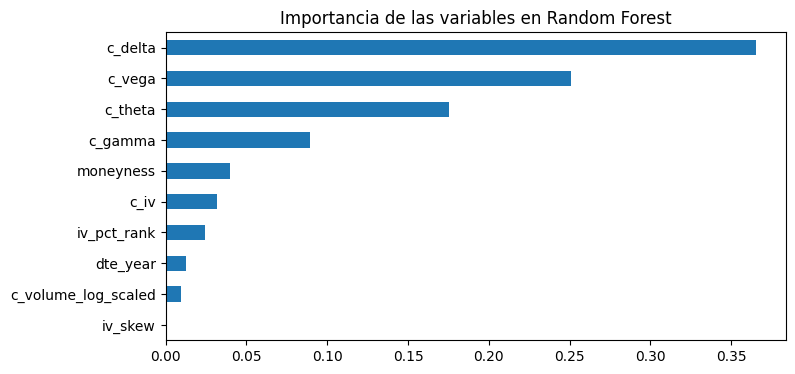

In [ ]:
import matplotlib.pyplot as plt

importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 4))
plt.title("Importancia de las variables en Random Forest")
plt.show()

## Conclusiones

- Si R² ≈ 0.37 → el modelo tiene cierta señal, pero predice mal en muchos casos.
- Si fuera negativo → el modelo sería peor que predecir el promedio.
- La variable con mayor importancia en el modelo es c_delta.
- Las relaciones cambiaron en 2023, y el modelo no se adapta bien (cambio de régimen o drift).
- RF no captura relaciones suaves y continuas entre variables.
- RF aprende reglas por tramos (divisiones o cortes), no curvas continuas.
- RF funciona mal con datos ruidosos, relaciones no lineales suaves, comportamientos casi deterministas (como Black-Scholes)
  * En opciones, el precio sigue fórmulas matemáticas continuas como Black-Scholes.
- Reentrenar con técnicas más robustas o adaptativas: XGBoost, RNA, otros.

In [ ]:
# Finished!